<a href="https://colab.research.google.com/github/yeesem/Soft-Computing/blob/main/Alternative_Assessment_Handwriting_Recognization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [20]:
import numpy as np
import pandas as pd
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tqdm import tqdm

# Dataset Loading and Preprocessing

In [21]:
!git clone https://github.com/Walmond3/WIX3001-Alt-Ass

fatal: destination path 'WIX3001-Alt-Ass' already exists and is not an empty directory.


**Image Cropping**

In [22]:
def crop_image_into_pieces(image_path, output_folder, rows, columns, owner):
    # Open the image
    image = Image.open(image_path)

    # Convert image to RGB mode (remove alpha channel)
    image = image.convert("RGB")

    # Get the dimensions of the original image
    original_width, original_height = image.size

    # Calculate the width and height of each piece
    piece_width = original_width // columns
    piece_height = original_height // rows

    # Initialize a list to store data for each cropped image
    cropped_images_data = []

    # Iterate through each row and column
    for row in range(rows):
        for col in range(columns):
            # Calculate the coordinates for cropping
            left = col * piece_width
            upper = row * piece_height
            right = left + piece_width
            lower = upper + piece_height

            # Crop the image
            cropped_img = image.crop((left, upper, right, lower))

            # Invert the colors
            inverted_img = ImageOps.invert(cropped_img)

            # Create output subfolder if it doesn't exist
            os.makedirs(output_folder, exist_ok=True)

            # Save the cropped image
            output_filename = f"{owner}_crop_{row}_{col}.jpg"
            output_filepath = os.path.join(output_folder, output_filename)
            inverted_img.save(output_filepath)

            # Append data to the list for DataFrame
            cropped_images_data.append({
                "Filename": output_filename,
                "Filepath": output_filepath,
                "Owner": owner
            })
            # print(f"Saved {output_filename}")

    print(f"All crops for {owner} saved!")

    return cropped_images_data

# Directory where the images are stored
images_directory = "/content/WIX3001-Alt-Ass/Handwriting"

# Output folder to save cropped images within Colab
output_folder = "/content/output_crops"

# Number of rows and columns in the grid
rows = 12
columns = 12

# Check if the images directory exists
if not os.path.exists(images_directory):
    print(f"Error: {images_directory} does not exist.")
    exit()

# List all files in the images directory
image_files = os.listdir(images_directory)

# Check if there are any image files
if not image_files:
    print(f"No image files found in {images_directory}.")
    exit()

# Initialize a list to store all cropped images data
all_cropped_images_data = []

# Iterate through each image file
for image_file in image_files:
    image_path = os.path.join(images_directory, image_file)
    owner, _ = os.path.splitext(image_file)  # Get owner from filename without extension
    cropped_images_data = crop_image_into_pieces(image_path, output_folder, rows, columns, owner)

    # Testing
    all_cropped_images_data.extend(cropped_images_data)

All crops for Yan Ho saved!
All crops for Jin Khye saved!
All crops for Hui Yi saved!
All crops for Yee Sem saved!
All crops for Yan Hao saved!


**Store data in DataFrame**

In [23]:
# Create a DataFrame from the list of cropped images data
df = pd.DataFrame(all_cropped_images_data)
df.head()

,Filename,Filepath,Owner
0,Yan Ho_crop_0_0.jpg,/content/output_crops/Yan Ho_crop_0_0.jpg,Yan Ho
1,Yan Ho_crop_0_1.jpg,/content/output_crops/Yan Ho_crop_0_1.jpg,Yan Ho
2,Yan Ho_crop_0_2.jpg,/content/output_crops/Yan Ho_crop_0_2.jpg,Yan Ho
3,Yan Ho_crop_0_3.jpg,/content/output_crops/Yan Ho_crop_0_3.jpg,Yan Ho
4,Yan Ho_crop_0_4.jpg,/content/output_crops/Yan Ho_crop_0_4.jpg,Yan Ho


**Display Images**

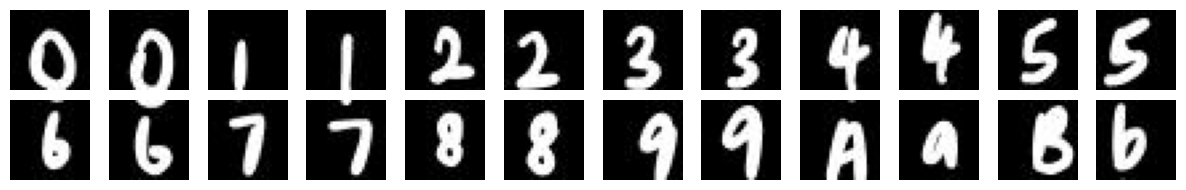

In [24]:
def display_images(filepaths):
    fig, axes = plt.subplots(len(filepaths) // columns, columns, figsize=(12, 2))
    for i, filepath in enumerate(filepaths):
        img = Image.open(filepath)
        ax = axes[i // columns, i % columns]
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()


# Display the images
display_images(df['Filepath'][:24])

**Dataset spliting**

In [25]:
from sklearn.model_selection import train_test_split


train,test = train_test_split(df,test_size=0.1, random_state=42)

In [26]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# # All images will be rescaled by 1./255
# train_datagen = ImageDataGenerator(rescale = 1/255)

# # Flow training images in batches of 128 using train_datagen generator
# train_generator = train_datagen.flow_from_dataframe(
#     train,
#     x_col='Filepath',
#     y_col = 'Owner',
#     class_mode = 'categorical'
# )

# # All images will be rescaled by 1./255
# test_datagen = ImageDataGenerator(rescale = 1/255)

# # Flow training images in batches of 128 using train_datagen generator
# test_generator = test_datagen.flow_from_dataframe(
#     test,
#     x_col='Filepath',
#     y_col = 'Owner',
#     class_mode = 'categorical'
# )

Found 648 validated image filenames belonging to 5 classes.
Found 72 validated image filenames belonging to 5 classes.


In [62]:
# Load Images
def load_and_preprocess_image(file_path):
    # Read the image file as raw data
    img = tf.io.read_file(file_path)
    # Decode the raw data into a tensor
    img = tf.image.decode_image(img, channels=3)
    return img

def format_image(image,label):
  image = tf.reshape(image,[-1])
  image = tf.cast(image, tf.float32)
  image /= 255
  return image, label

label_mapping = {'Yan Ho' : 0,'Jin Khye' : 1,'Hui Yi' : 2,'Yee Sem' : 3,'Yan Hao' : 4}

# Train dataset
train_image_paths = train['Filepath'].tolist()
train_label = train['Owner'].map(label_mapping).tolist()

# Test dataset
test_image_paths = test['Filepath'].tolist()
test_label = test['Owner'].map(label_mapping).tolist()

# Load all images
train_images = [load_and_preprocess_image(path) for path in train_image_paths]
train_image_dataset = tf.data.Dataset.from_tensor_slices((train_images,train_label))

test_images = [load_and_preprocess_image(path) for path in test_image_paths]
test_dataset = tf.data.Dataset.from_tensor_slices((test_images,test_label))

In [63]:
batch_size = 32
train_dataset = train_image_dataset.shuffle(buffer_size=len(train)).batch(batch_size)

In [27]:
class_names = list(df["Owner"].unique())
class_names

['Yan Ho', 'Jin Khye', 'Hui Yi', 'Yee Sem', 'Yan Hao']

# Distributed Training

In [28]:
# Detect hardware
try:
  # TPU Detector
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
except ValueError:
  tpu = None
  gpus = tf.config.experimental.list_logical_devices("GPU")

# Select appropriate distribution strategy
if tpu:
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu)
  print("Running on TPU ",tpu.cluster_spec().as_dict()['worker'])
elif len(gpus) > 1:
  strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
  print("Running on multiple GPUs ",[gpu.name for gpu in gpus])
elif len(gpus) == 1:
  # strategy for single-machine execution
  strategy = tf.distribute.get_strategy()
  print("Running on single GPU ",gpus[0].name)
else:
  # strategy for single-machine execution
  strategy = tf.distribute.get_strategy()
  print("Running on single CPU ")

print("Number of accelerators ",strategy.num_replicas_in_sync)

Running on single GPU  /device:GPU:0
Number of accelerators  1


# Parameter

# Define the Model

**Define Optimizers and Loss function**

In [29]:
# Define Optimizer and Loss Function
adam_optimizer = tf.keras.optimizers.legacy.Adam()
categorical_loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

# Define metrics
train_acc_metrics = tf.keras.metrics.SparseCategoricalAccuracy()
test_acc_metrics = tf.keras.metrics.SparseCategoricalAccuracy()

**Define gradient and training loop**

In [57]:
def apply_gradient(optimizer,model,loss_object,x,y):
  with tf.GradientTape() as tape:
    pred = model(x)
    loss_value = loss_object(y_true = y,y_pred = pred)

  gradients = tape.gradient(loss_value,model.trainable_weights)
  optimizer.apply_gradients(zip(gradients,model.trainable_weights))

  return pred,loss_value

In [36]:
def perform_validation(model,loss_object,test):
  losses = []
  for x_val,y_val in test:
    val_pred = model(x_val)
    val_loss = loss_object(y_true = y_val,y_pred = val_pred)

    losses.append(val_loss)
    test_acc_metrics(val_pred,y_val)

  return losses

In [65]:
def train_data_for_one_epoch(train,optimizer,model,loss_object):
  losses = []

  pbar = tqdm(total = len(list(enumerate(train))),position = 0, leave = True, bar_format = '{l_bar}{bar} | {n_fmt}/{total_fmt}')
  for atep,(x_batch_train,y_batch_train) in enumerate(train):
    pred,loss_value = apply_gradient(optimizer,model,loss_object,x_batch_train,y_batch_train)
    losses.append(loss_value)

    train_acc_metrics(y_batch_train,pred)
    pbar.set_description("Training loss for step %s: %.4f" % (int(step),float(loss_value)))
    pbar.update()


  return losses

**Transfer Learning - InceptionV3**

In [33]:
# Download the pre-trained weights. No top means it excludes the fully connected layer it uses for classification.
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2024-05-21 15:02:46--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 74.125.137.207, 142.250.141.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   117MB/s    in 0.7s    

2024-05-21 15:02:47 (117 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [66]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import optimizers
from tensorflow.keras import Model
from tensorflow.keras import layers


def feature_extractor_inceptionV3(inputs):
  # Set the weights file you downloaded into a variable
  local_weights_file = "/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"

  # Initialize the base model
  # Set the input shape and remove the dense layer
  feature_extractor = InceptionV3(input_shape = (300,300,3),
                                  include_top = False,
                                  weights = None)
  # Load the pre-trained weights
  feature_extractor.load_weights(local_weights_file)

  # Freeze the weights of the layers
  for layer in feature_extractor.layers:
    layer.trainable = False

  feature_extractor = feature_extractor(inputs)

  return feature_extractor

def classifier(inputs):
  x = layers.GlobalAveragePooling2D()(inputs)
  x = layers.Flatten()(x)
  x = layers.Dense(1024,activation = 'relu')(x)
  x = layers.Dense(512,activation = 'relu')(x)
  x = layers.Dense(5,activation = 'softmax')(x)

  return x

def model_1():
  inputs = layers.Input(shape = (30,30,3))
  resize = layers.UpSampling2D(size = (10,10))(inputs)
  inception = feature_extractor_inceptionV3(resize)
  classification_output = classifier(inception)
  model = Model(inputs = inputs,outputs = classification_output)

  return model

def train_model_1(epochs = 10):
  model = model_1()
  epochs_test_losses,epochs_train_losses = [],[]

  for epoch in range(epochs):
    print("Epoch : ",epoch)

    losses_train = train_data_for_one_epoch(train_dataset,adam_optimizer,model,categorical_loss_object)
    train_acc = train_acc_metrics.result()

    losses_test = perform_validation(model,categorical_loss_object,test_dataset)
    test_acc = test_acc_metrics.result()

    losses_train_mean = np.mean(losses_train)
    losses_test_mean = np.mean(losses_test)
    epochs_train_losses.append(losses_train_mean)
    epochs_test_losses.append(losses_test_mean)

    print("Train loss : {6:.4f}, Validation loss : {6:.4f}, Train Accuracy : {6:.3f}, Test Accuracy : {6:.3f}".format(
        float(losses_train_mean),float(losses_test_mean),float(train_acc),float(test_acc)
    ))

    train_acc_metrics.reset_states()
    test_acc_metrics.reset_states()

train_model_1()

Epoch :  0


  0%|           | 0/21

NameError: name 'step' is not defined

In [44]:
train_generator

In [ ]:
model.compile(optimizer = RMSprop(learning_rate = 0.0001),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = ['accuracy'])

In [ ]:
model.fit(
    train_generator,
    epochs = 15,
    batch_size = 32
)

Epoch 1/15
21/21 [==============================] - 13s 397ms/step - loss: 1.4437 - accuracy: 0.4444
Epoch 2/15
21/21 [==============================] - 7s 310ms/step - loss: 0.9682 - accuracy: 0.6265
Epoch 3/15
21/21 [==============================] - 13s 628ms/step - loss: 0.7800 - accuracy: 0.7083
Epoch 4/15
21/21 [==============================] - 14s 637ms/step - loss: 0.6822 - accuracy: 0.7593
Epoch 5/15
21/21 [==============================] - 7s 335ms/step - loss: 0.5845 - accuracy: 0.7994
Epoch 6/15
21/21 [==============================] - 10s 458ms/step - loss: 0.5260 - accuracy: 0.8241
Epoch 7/15
21/21 [==============================] - 8s 402ms/step - loss: 0.4573 - accuracy: 0.8472
Epoch 8/15
21/21 [==============================] - 6s 304ms/step - loss: 0.4137 - accuracy: 0.8642
Epoch 9/15
21/21 [==============================] - 8s 400ms/step - loss: 0.3771 - accuracy: 0.8843
Epoch 10/15
21/21 [==============================] - 7s 329ms/step - loss: 0.3163 - accuracy: 0.

# Visualize Results

# Visualize Predictions

Found 72 validated image filenames belonging to 5 classes.
1/1 [==============================] - 0s 427ms/step


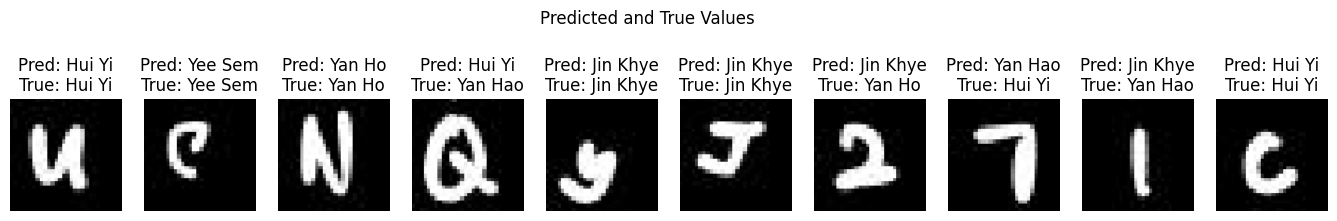

In [ ]:
def display_images(images, predictions, labels, title, n):
    fig, axes = plt.subplots(1, n, figsize=(17, 3))
    fig.suptitle(title)

    for i in range(n):
        axes[i].imshow(images[i])
        axes[i].set_title(f"Pred: {predictions[i]}\nTrue: {labels[i]}")
        axes[i].axis('off')

    plt.show()

x_batches, y_pred_batches, y_true_batches = [], [], []

for x, y in test_generator:
    y_pred = model.predict(x)
    y_pred_batches.append(y_pred)
    y_true_batches.append(y)
    x_batches.append(x)

    if len(y_pred_batches) >= 10:  # Stopping condition: display 10 images
        break

x_batches = np.concatenate(x_batches)
y_pred_batches = np.concatenate(y_pred_batches)
y_true_batches = np.concatenate(y_true_batches)

indexes = np.random.choice(len(y_pred_batches), size=10)
images_to_plot = x_batches[indexes]
y_pred_to_plot = y_pred_batches[indexes]
y_true_to_plot = y_true_batches[indexes]

y_pred_labels = [class_names[np.argmax(sel_y_pred)] for sel_y_pred in y_pred_to_plot]
y_true_labels = [class_names[np.argmax(sel_y_true)] for sel_y_true in y_true_to_plot]
display_images(images_to_plot, y_pred_labels, y_true_labels, "Predicted and True Values", 10)